In [1]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [2]:
import numpy as np 
import pandas as pd 
import random
import cv2
import os

In [3]:
os.chdir("/content/gdrive/MyDrive/ML Project/Mushroom Research Paper")

In [4]:
clss = os.listdir()
clss

['rawDataV2',
 'rawData',
 'IJRTE_Paper_Template.doc',
 'Untitled0.ipynb',
 'Mushroom notes.docx',
 'PredictionFromDenseNet',
 'Mushroom k2.docx',
 'fullScaleClassifier.ipynb',
 'INTRODUCTION.docx',
 'Agaricus Bisporus',
 'Death Cap',
 'Galerina Autumnalis',
 'Oyster',
 'rawDataFull_Shuflled',
 'rawDataFULL',
 'data_files',
 'config.py',
 'make_generator_dataset.ipynb',
 'test2.ipynb',
 'training_with_data_generator.ipynb']

In [5]:
from PIL import Image
import matplotlib.pyplot as plt


import cv2
from sklearn.utils import shuffle

from keras.utils import np_utils

In [6]:
def load_samples(csv_file):
    data = pd.read_csv(os.path.join('data_files',csv_file))
    data = data[['FileName', 'Label', 'ClassName']]
    file_names = list(data.iloc[:,0])
    # Get the labels present in the second column
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

In [7]:
data_path = 'mushroom_recognition_train.csv'
samples = load_samples(data_path)

In [8]:
print (samples[0:5])

[['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_004.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_007.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_003.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_005.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_014.jpg', 0]]


In [9]:
def shuffle_data(data):
    data = shuffle(data)#,random_state=2)
    return data

In [10]:
def preprocessing(img,label):
    img = cv2.resize(img,(300,300))
    img = img/255
    label = np_utils.to_categorical(label, 4)
    return img,label

In [11]:
def data_generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join("",img_name))
                
                # apply any kind of preprocessing
                img,label = preprocessing(img,label)
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [12]:
# this will create a generator object
train_datagen = data_generator(samples,batch_size=8)

x,y = next(train_datagen)
print ('x_shape: ', x.shape)
print ('labels shape: ', y.shape)
print ('labels: ', y)

x_shape:  (8, 300, 300, 3)
labels shape:  (8, 4)
labels:  [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [13]:
train_data_path = 'mushroom_recognition_train.csv'
test_data_path = 'mushroom_recognition_test.csv'

train_samples = load_samples(train_data_path)
test_samples = load_samples(test_data_path)

num_train_samples = len(train_samples)
num_test_samples = len(test_samples)

print ('number of train samples: ', num_train_samples)
print ('number of test samples: ', num_test_samples)

number of train samples:  1412
number of test samples:  799


In [14]:
# Create generator
batch_size = 10
train_generator = data_generator(train_samples, batch_size=32)
validation_generator = data_generator(test_samples, batch_size=32)

In [15]:
# import the necessary modules from the library
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout

input_shape = (300,300,3)
print (input_shape)

model = Sequential()

#filters,kernel_size,strides=(1, 1),padding='valid',data_format=None,dilation_rate=(1, 1),activation=None,use_bias=True,
#kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,
#activity_regularizer=None,kernel_constraint=None,bias_constraint=None,

#pool_size=(2, 2), strides=None, padding='valid',data_format=None

model.add(Conv2D(32, (3,3),padding='same',input_shape=input_shape,name='conv2d_1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_1'))

model.add(Conv2D(32, (3, 3),name='conv2d_2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))

model.add(Dropout(0.5))

#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

(300, 300, 3)


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 300, 300, 32)      0         
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0

In [17]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='sgd')

In [18]:
history_mdl1=model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=num_test_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
141/141 [==============================] - 1035s 7s/step - loss: 1.3535 - acc: 0.3495 - val_loss: 1.1889 - val_acc: 0.4883
Epoch 2/10
141/141 [==============================] - 513s 4s/step - loss: 1.1866 - acc: 0.4979 - val_loss: 1.1383 - val_acc: 0.5053
Epoch 3/10
141/141 [==============================] - 515s 4s/step - loss: 1.0945 - acc: 0.5517 - val_loss: 1.0730 - val_acc: 0.5640
Epoch 4/10
141/141 [==============================] - 520s 4s/step - loss: 1.0212 - acc: 0.5910 - val_loss: 0.9802 - val_acc: 0.5881
Epoch 5/10
141/141 [==============================] - 527s 4s/step - loss: 0.9628 - acc: 0.6184 - val_loss: 1.0086 - val_acc: 0.5655
Epoch 6/10
141/141 [==============================] - 516s 4s/step - loss: 0.8812 - acc: 0.6543 - val_loss: 1.0318 - val_acc: 0.5707
Epoch 7/10
141/141 [==============================] - 518s 4s/step - loss: 0.8575 - acc: 0.6491 - val_loss: 1.0281 - val_acc: 0.5687
Epoch 8/10
141/141 [==============================] - 510s 4s/step -

In [19]:
print(history_mdl1.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


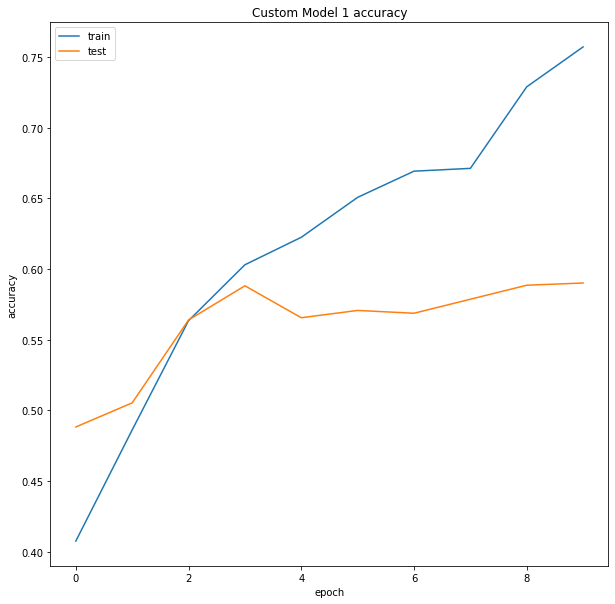

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(history_mdl1.history['acc'])
plt.plot(history_mdl1.history['val_acc'])
plt.title('Custom Model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

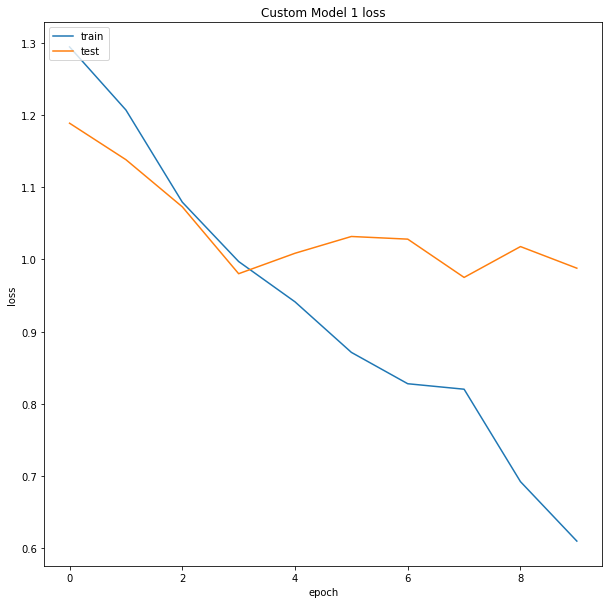

In [21]:
plt.figure(figsize=(10,10))
plt.plot(history_mdl1.history['loss'])

plt.plot(history_mdl1.history['val_loss'])
plt.title('Custom Model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
#Save weights
model.save_weights('cutom_model_1_v1.h5')

In [23]:
history_mdl1=model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=num_test_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
141/141 [==============================] - 524s 4s/step - loss: 0.5517 - acc: 0.7857 - val_loss: 0.9975 - val_acc: 0.6222
Epoch 2/30
141/141 [==============================] - 517s 4s/step - loss: 0.4606 - acc: 0.8173 - val_loss: 1.0475 - val_acc: 0.6004
Epoch 3/30
141/141 [==============================] - 518s 4s/step - loss: 0.4567 - acc: 0.8214 - val_loss: 1.0714 - val_acc: 0.6048
Epoch 4/30
141/141 [==============================] - 518s 4s/step - loss: 0.3669 - acc: 0.8546 - val_loss: 1.3149 - val_acc: 0.5834
Epoch 5/30
141/141 [==============================] - 522s 4s/step - loss: 0.3157 - acc: 0.8730 - val_loss: 1.0673 - val_acc: 0.6277
Epoch 6/30
141/141 [==============================] - 527s 4s/step - loss: 0.2326 - acc: 0.9067 - val_loss: 1.3137 - val_acc: 0.6036
Epoch 7/30
141/141 [==============================] - 525s 4s/step - loss: 0.2032 - acc: 0.9196 - val_loss: 1.3320 - val_acc: 0.6099
Epoch 8/30
141/141 [==============================] - 528s 4s/step - 